# Seq2Seq Translation with Attention

In [1]:
from fastai.text.all import *
from utils import *

In [3]:
path = Config.config_path/"giga-fren"
df = pd.read_csv(path/"questions_easy.csv")
df["en"] = df["en"].apply(lambda x: x.lower())
df["fr"] = df["fr"].apply(lambda x: x.lower())
df.tail()

,en,fr
52326,what are the mechanisms for increasing women's participation?,quels sont les mécanismes susceptibles d’améliorer cette participation?
52327,"why is it still pushed aside, silenced, or the subject of jokes?","pourquoi, aujourd'hui encore, écarte-t-on cette question, la passe-t-on sous silence ou en fait-on un sujet de plaisanterie?"
52328,"why should they not demote a judge who rules against the government, or send the judge to some remote backwater as a reward for contrariness?",pourquoi ne devraient-ils pas destituer un juge qui rend une décision défavorable au gouvernement ou l'envoyer en quelque région reculée parce qu'il les a contrariés?
52329,why is it that we have achieved judicial independence when others have a hard time even understanding it?,pourquoi avons-nous réussi à atteindre l'indépendance de la magistrature alors que d'autres ont encore de la difficulté à comprendre ce concept?
52330,what's inside introduction to sti did you know…?,contenu introduction aux its saviez-vous que…?


In [42]:
sl = 30

dls = DataBlock(
    blocks=(TextBlock.from_df("fr", tok=SpacyTokenizer("fr"), seq_len=sl),
            TextBlock.from_df("en", tok=SpacyTokenizer("en"), seq_len=sl)),
    get_x=ColReader("text"), get_y=ColReader("text"),
    splitter=RandomSplitter(0.1)
).dataloaders(df, bs=64, num_workers=os.cpu_count(), seq_len=sl)
dls.show_batch(max_n=3)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos dans un tel cas , où il s’ agit d ’ apprécier si un nom commercial a un fondement juridique antérieur à celui d ’ une marque aux fins de l’ article 16 , paragraphe 1 , troisième phrase , de l’ accord adpic , peut -on considérer comme décisif : i ) le fait que , dans l’ état où la marque est enregistrée et sa protection réclamée , le nom commercial ait été , du moins dans une certaine mesure , connu dans les milieux professionnels xxunk xxunk de l’ état concerné avant la date à laquelle l’ enregistrement de la marque y a été demandé ; ou que , dans les relations commerciales intéressant l’ état où la marque est xxunk ée et sa protection réclamée , le nom commercial ait été utilisé avant la date à laquelle l’ enregistrement de la marque a été demandé","xxbos when assessing , in such a case , whether a trade name has a legal basis prior to a trade mark for the purposes of the third sentence of article 16(1 ) of the trips agreement , may it thus be considered as decisive : ( i ) whether the trade name was well known at least to some extent among the relevant trade circles in the state in which the trade mark is registered and in which protection is sought for it , before the point in time at which registration of the trade mark was applied for in the state in question ; or whether the trade name was used in commerce directed to the state in which the trade mark is registered and in which protection is sought for it , before the point in time at which registration of the trade mark was applied for in the state in question ; or what other factor may decide whether the trade name is to be regarded as an existing prior right within the meaning of the third sentence of article 16(1 ) of the trips agreement ?"
1,"xxbos quels types de délits en matière de propriété intellectuelle sont enregistrés en australie ( en particulier , quel est le volume de marchandises de contrefaçon et de marchandises pirates sur le marché ) et quel aspect des délits en matière de propriété intellectuelle a le plus d’ impact ( par exemple , la distribution à petite échelle , l’ implication du crime organisé , l’ importation des produits ou leur fabrication locale , la diffusion en ligne de musique , de films , d’ émissions xxunk ou de logiciels d’ entreprise ) ?","xxbos what kind of ip crime is affecting australia ( ie what is the volume of counterfeit / pirated goods on the market ) and what aspect of ip crime is xxunk the most ( eg small - scale market distribution , organised crime involvement , cross - border importation or domestic manufacture , online distribution of music , film , television and business software products ) ?"
2,"xxbos deux questions xxunk le projet : quels changements sont nécessaires à l' école pour que la mise en oeuvre de pratiques et de xxunk xxunk parviennent à atteindre le double objectif de la réussite et de l' égalité ; et quels sont les obstacles et les possibilités actuels pour relier les besoins des parents et de la communauté aux résultats des recherches et aux meilleures pratiques quand il faut maximiser le potentiel d' apprentissage , les rôles de vie adulte et les perspectives de carrière des étudiants à risques ?",xxbos what changes need to happen for schools in the implementation of inclusive education philosophy and practice to achieve xxunk goals of excellence and equity ?


In [43]:
m = np.array([len(st.split(" ")) for st in df.to_numpy()[:, 0]])
np.where(m > 50)

(array([ 3514,  3571,  7127,  7381,  7382,  7469,  8196,  8205,  9277,
         9343, 10073, 11388, 11671, 13900, 17602, 17605, 19245, 19935,
        21893, 22414, 22475, 22476, 22478, 24131, 24314, 24389, 24611,
        25905, 26362, 26365, 26372, 26373, 26983, 27535, 29495, 29643,
        30264, 30508, 31297, 31643, 32052, 32192, 33303, 34690, 35244,
        35413, 35794, 35799, 36506, 36624, 36706, 36790, 37142, 37635,
        37749, 37945, 39059, 40286, 40344, 40462, 40466, 41088, 41691,
        41716, 41948, 41983, 42512, 43437, 43628, 43727, 43730, 43731,
        43732, 44374, 44532, 44676, 44806, 45098, 45310, 45441, 45565,
        46404, 46481, 46967, 47242, 47442, 47506, 47596, 47654, 47743,
        47797, 47910, 47934, 48381, 48625, 48905, 49375, 49777, 49914,
        50031, 50035, 50694, 50869, 51484, 51838, 51939, 51987, 52294]),)

In [44]:
model_path = Config.config_path/"models"
emb_enc = torch.load(model_path/"fr_emb.pth")
emb_dec = torch.load(model_path/"en_emb.pth")

In [45]:
emb_dec

Embedding(9112, 300, padding_idx=1)

In [46]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs, targ_len = targ.size()
    _, out_len, vs = out.size()
    if targ_len > out_len: out = F.pad(out, (0, 0, 0, targ_len - out_len, 0, 0), value=pad_idx)
    if out_len > targ_len: targ = F.pad(targ, (0, out_len - targ_len, 0, 0), value=pad_idx)
    return CrossEntropyLossFlat()(out, targ)


def seq2seq_acc(out, targ, pad_idx=1):
    bs, targ_len = targ.size()
    _, out_len, vs = out.size()
    if targ_len > out_len: out = F.pad(out, (0, 0, 0, targ_len - out_len, 0, 0), value=pad_idx)
    if out_len > targ_len: targ = F.pad(targ, (0, out_len - targ_len, 0, 0), value=pad_idx)
    out = out.argmax(2)
    return (out == targ).float().mean()

In [47]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [48]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [49]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [56]:
class GetPreds:
    def __init__(self, inputs, preds, targs):
        self.inputs, self.preds, self.targs = inputs, preds, targs

    def get_predictions(self, num, ignore_pad=False): 
        """:ignore_pad: Whether to ignore pad for predictions. Default: False"""
        return (
            itos(dls.vocab[0], self.inputs[num], join=True, ignore_pad=True),
            itos(dls.vocab[1], self.targs[num], join=True, ignore_pad=True),
            itos(dls.vocab[1], self.preds[num].argmax(1), join=True, ignore_pad=ignore_pad)
        )

In [51]:
class TeacherForcing(Callback):
    def __init__(self, end_epoch, full_force_for=0): 
        self.fff = full_force_for - 1  # start counting from zero. 
        self.end_epoch = end_epoch
    
    def before_batch(self): 
        self.learn.xb = (self.x, self.y)

    def before_epoch(self):
        self.learn.model.pr_force = 1 - ((self.learn.epoch - self.fff) / (self.end_epoch - self.fff))
        if self.learn.epoch <= self.fff: self.learn.model.pr_force = 1

## Implementing Attention

In [52]:
class Seq2SeqRNN_attn(Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        self.nl, self.nh, self.out_sl, self.pr_force = nl, nh, out_sl, 1
        self.bos_idx, self.pad_idx = bos_idx, pad_idx
        self.emb_enc, self.emb_dec = emb_enc, emb_dec
        self.emb_sz_enc, self.emb_sz_dec = emb_enc.embedding_dim, emb_enc.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings

        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.emb_sz_enc, nh, num_layers=nl, dropout=0.25,
                        batch_first=True, bidirectional=True)
        self.out_enc = nn.Linear(2 * nh, self.emb_sz_dec, bias=False)

        self.gru_dec = nn.GRU(self.emb_sz_dec + 2 * nh, self.emb_sz_dec, num_layers=nl,
                        dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.emb_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data

        self.enc_att = nn.Linear(2 * nh, self.emb_sz_dec, bias=False)
        self.hid_att = nn.Linear(self.emb_sz_dec, self.emb_sz_dec)
        self.V = self.init_param(self.emb_sz_dec)

    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, hid = self.gru_enc(emb, 2 * h)

        pre_hid = hid.view(2, self.nl, bs, self.nh).permute(1, 2, 0, 3).contiguous()
        pre_hid = pre_hid.view(self.nl, bs, 2 * self.nh)
        hid = self.out_enc(pre_hid)

        return hid, enc_out

    def decoder(self, dec_inp, hid, enc_att, enc_out):
        hid_att = self.hid_att(hid[-1])

        # enc_out and hid through linear layers
        u = torch.tanh(enc_att + hid_att[:, None])

        # Learn importance each time step
        attn_wgts = F.softmax(u @ self.V, 1)

        # weighted average of enc_out (output at every time step)
        ctx = (attn_wgts[..., None] * enc_out).sum(1)
        emb = self.emb_dec(dec_inp)

        # Concat decoder embed with context
        outp, hid = self.gru_dec(torch.cat([emb, ctx], 1)[:, None], hid)
        outp = self.out(self.out_drop(outp[:, 0]))
        return hid, outp

    def show(self, nm, v): 
        if False: print(f"{nm}={v[nm].shape}")

    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        hid, enc_out = self.encoder(bs, inp)
        # self.show("hid", vars())
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        enc_att = self.enc_att(enc_out)

        res = []

        for i in range(self.out_sl):
            hid, outp = self.decoder(dec_inp, hid, enc_att, enc_out)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break

            if (targ is not None) and (random.random() < self.pr_force):
                if i >= targ.shape[1]: continue
                assert dec_inp.shape == targ[:, i].shape
                dec_inp = targ[:, i]
        
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(2 * self.nl, bs, self.nh)
    def init_param(self, *sz): return nn.Parameter(torch.randn(sz) / math.sqrt(sz[0]))

In [53]:
model = Seq2SeqRNN_attn(emb_enc, emb_dec, 256, 30)
model

Seq2SeqRNN_attn(
  (emb_enc): Embedding(11600, 300, padding_idx=1)
  (emb_dec): Embedding(9112, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15, inplace=False)
  (gru_enc): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (out_enc): Linear(in_features=512, out_features=300, bias=False)
  (gru_dec): GRU(812, 300, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=300, out_features=9112, bias=True)
  (enc_att): Linear(in_features=512, out_features=300, bias=False)
  (hid_att): Linear(in_features=300, out_features=300, bias=True)
)

SuggestedLRs(valley=tensor(0.0003))

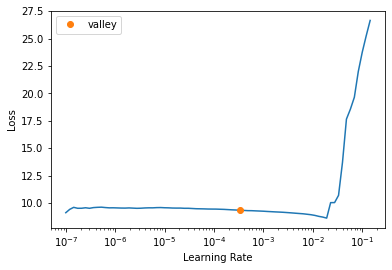

In [54]:
torch.cuda.empty_cache()
learn = Learner(dls, model, loss_func=seq2seq_loss, 
            metrics=[seq2seq_acc, CorpusBLEUMetric(len(dls.vocab[1]))],
            cbs=[TeacherForcing(30, 3)])
learn.lr_find()

In [55]:
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,seq2seq_acc,corpus_bleu,time
0,3.274745,3.290447,0.550881,0.366174,02:54
1,2.696936,2.795808,0.604760,0.386262,02:30
2,2.403678,2.460868,0.640072,0.408413,02:29
3,2.003400,2.324944,0.651999,0.431581,02:28
4,2.225621,2.254841,0.659783,0.427665,02:27
5,1.981703,2.263620,0.661931,0.433464,02:26
6,1.860337,2.396944,0.648175,0.417830,02:26
7,1.966225,2.274959,0.661903,0.440676,02:26
8,1.828020,2.370565,0.653450,0.431299,02:25
9,1.773579,2.422613,0.649914,0.433362,02:24


In [57]:
inputs, preds, targs = learn.get_preds(with_input=True)
p = GetPreds(inputs[0], preds, targs)

It seems like this have 2 input features, and `inputs[0]` matches their english equivalent. One isn't sure that does `inputs[1]` represents here. 

In [73]:
p.get_predictions(700)

("xxbos quels étaient vos plans en cas d' échec au concours ?",
 'xxbos what were your plans if you were to be unsuccessful in the competition ?',
 'xxbos what were your plans if you were to be unsuccessful in the competition ? xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad')

In [74]:
p.get_predictions(701)

('xxbos quelles sont vos responsabilités en qualité de gestionnaire dans ce processus ?',
 'xxbos what are you responsibilities as a manager in this process ?',
 'xxbos what are your in as a manager in this process ? xxpad xxpad xxpad xxpad xxpad xxpad xxpad')

In [78]:
p.get_predictions(4002)  # this is very funny

("xxbos comment s' en passer ?",
 'xxbos what would we do without it ?',
 'x x p a d')

In [79]:
p.get_predictions(4010)

('xxbos quelle est votre priorité - la salubrité ou la nutrition ?',
 'xxbos which is your priority - safety or nutrition ?',
 'xxbos what is your priority safety food or nutrition ? xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad')